In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense, Input, Flatten, Conv2D, MaxPooling2D, LayerNormalization, Softmax
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
import tensorflow_probability as tfp
import keras

In [2]:
#training, testing = tf.keras.datasets.mnist.load_data(path="mnist.npz")
training, testing = tf.keras.datasets.fashion_mnist.load_data()



images_training = training[0]/256
images_testing = testing[0]/256

labels_training = pd.get_dummies(training[1]).to_numpy()
labels_testing = pd.get_dummies(testing[1]).to_numpy()

In [16]:
def generate_gaussian_noise(images,noise_sd):
    #Adds random gaussian noise to images
    noisy_images = images + np.random.normal(0,noise_sd,np.shape(images))
    return noisy_images

def generate_gaussian_noise_range(images,noise_sd):    
    #Adds random gaussian noise to images. The sd of gaussian is uniformly distributed 
    #between [0,noise_sd]
    noisy_images = np.zeros(np.shape(images))
    
    for i in range(np.shape(images)[0]):
        noise = np.random.uniform(0,noise_sd)
        noisy_images[i,:,:] = images[i,:,:] + np.random.normal(0,noise,np.shape(images[i,:,:]))
    return noisy_images


def generate_dropout_pixel_range(images,dropout_level, replace=0.5):    
    #Adds random gaussian noise to images. The sd of gaussian is uniformly distributed 
    #between [0,noise_sd]
    dropout_images = np.zeros(np.shape(images))
    
    for i in range(np.shape(images)[0]):
        dropout = np.random.uniform(0,dropout_level)
        
        for j in range(np.shape(images)[1]):
            for k in range(np.shape(images)[2]):
                
                if np.random.rand(1,)[0] < dropout:
                    dropout_images[i,j,k] = replace
                else:
                    dropout_images[i,j,k] = images[i,j,k]       
                    
        
    return dropout_images


def generate_contrast(images,a):
    
    contrasted_images = np.zeros(np.shape(images))
    #changes contrast based on alpha
    alpha = a
    for i in range(np.shape(images)[0]):
        for j in range(np.shape(images)[1]):
            for k in range(np.shape(images)[2]):
                if images[i,j,k] < 0.5:
                    contrasted_images[i,j,k] = 0.5*(2*images[i,j,k])**alpha
                    
                else:
                    contrasted_images[i,j,k] = 1 - 0.5*(2*(1-images[i,j,k]))**alpha
    
    return contrasted_images

def generate_pixel_dropout(images,dropout, replace=0.5):
    dropout_images = np.zeros(np.shape(images))

    for i in range(np.shape(images)[0]):
        for j in range(np.shape(images)[1]):
            for k in range(np.shape(images)[2]):
                if np.random.rand(1,)[0] < dropout:
                    dropout_images[i,j,k] = replace
                else:
                    dropout_images[i,j,k] = images[i,j,k]                       
                    
     
    
    return dropout_images

def display_images(images,n=10):
    #Displays first n images
    plt.figure(10000)
    fig, ax = plt.subplots(1,n,figsize=(15,15))
    for i in range(n):
        ax[i].imshow(images[i])  
    plt.show()
    
def compute_accuracy(actual_labels, predicted_labels):
    c = 0
    for i in range(len(actual_labels[:,0])):
        if np.argmax(actual_labels[i,:]) == np.argmax(predicted_labels[i,:]):
            c = c+1
            
    return c/len(actual_labels[:,0])
        
def compute_confidence(actual_labels, predicted_labels):
    c = 0
    all_conf = 0 
    correct_conf = 0
    for i in range(len(actual_labels[:,0])):
        if np.argmax(actual_labels[i,:]) == np.argmax(predicted_labels[i,:]):
            c = c+1
            correct_conf = predicted_labels[i,np.argmax(predicted_labels[i,:])] + correct_conf
        all_conf = predicted_labels[i,np.argmax(predicted_labels[i,:])] + all_conf
        
    all_conf = all_conf/len(actual_labels[:,0])
    correct_conf = correct_conf/c
    
    return all_conf,correct_conf

def compute_frequencies(predicted_labels):
    freq = np.zeros((10,1))
    for i in range(len(predicted_labels[:,0])): 
        freq[np.argmax(predicted_labels[i,:]),0] = 1 + freq[np.argmax(predicted_labels[i,:]),0]
        
    freq = freq/len(predicted_labels[:,0])
        
    return freq
        
    
def compute_confidence_by_category(actual_labels, predicted_labels):
    c = np.zeros((10,1))
    cc = np.zeros((10,1))
    all_conf = np.zeros((10,1))
    correct_conf = np.zeros((10,1))
    
    for j in range(10):
        for i in range(len(actual_labels[:,0])):
            if np.argmax(predicted_labels[i,:]) == j:
                cc[j] = cc[j] + 1
                if np.argmax(actual_labels[i,:]) == np.argmax(predicted_labels[i,:]):
                    c[j] = c[j]+1
                    correct_conf[j] = predicted_labels[i,np.argmax(predicted_labels[i,:])] + correct_conf[j]
                all_conf[j] = predicted_labels[i,np.argmax(predicted_labels[i,:])] + all_conf[j]

        all_conf[j] = all_conf[j]/cc[j]
        correct_conf[j] = correct_conf[j]/c[j]
    
    return all_conf,correct_conf

Clean Data


<Figure size 432x288 with 0 Axes>

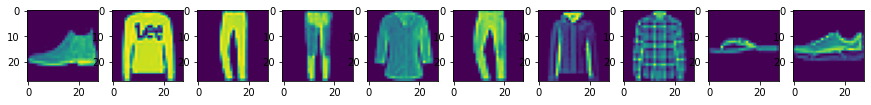

Noisy Data


<Figure size 432x288 with 0 Axes>

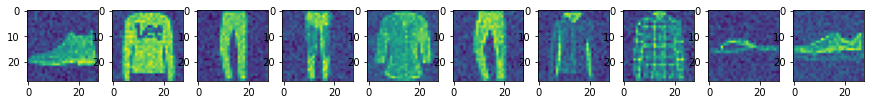

<Figure size 432x288 with 0 Axes>

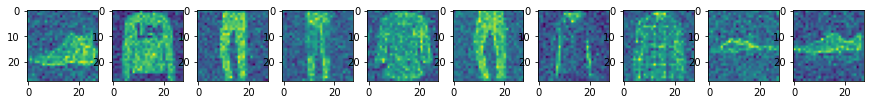

<Figure size 432x288 with 0 Axes>

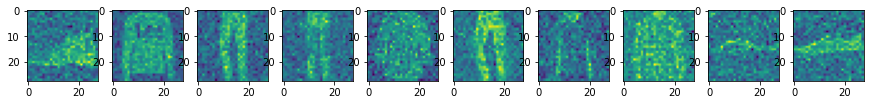

<Figure size 432x288 with 0 Axes>

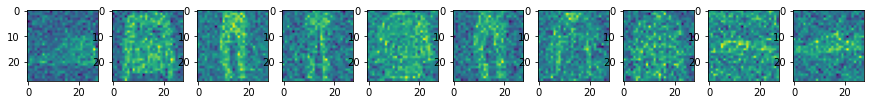

<Figure size 432x288 with 0 Axes>

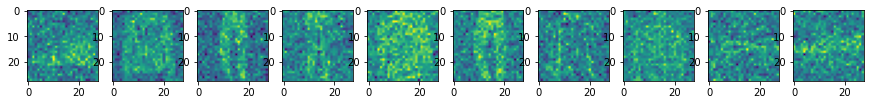

<Figure size 432x288 with 0 Axes>

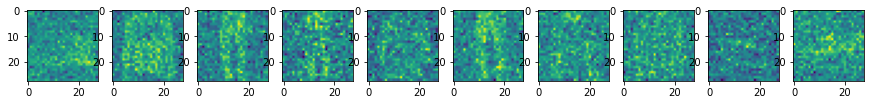

<Figure size 432x288 with 0 Axes>

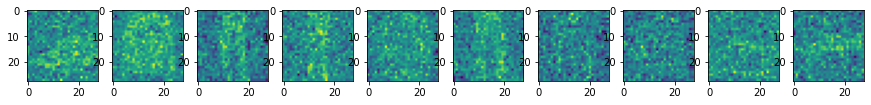

<Figure size 432x288 with 0 Axes>

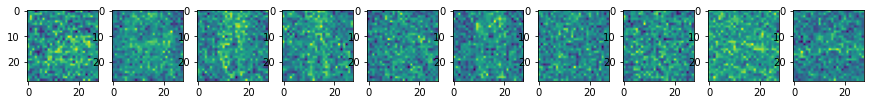

<Figure size 432x288 with 0 Axes>

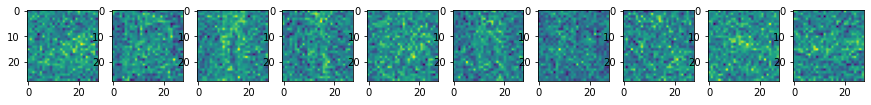

<Figure size 432x288 with 0 Axes>

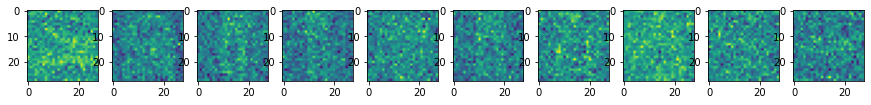

<Figure size 432x288 with 0 Axes>

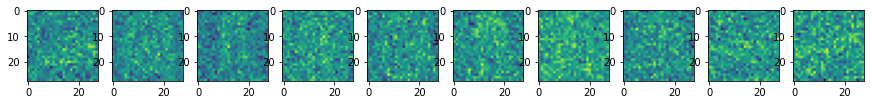

<Figure size 432x288 with 0 Axes>

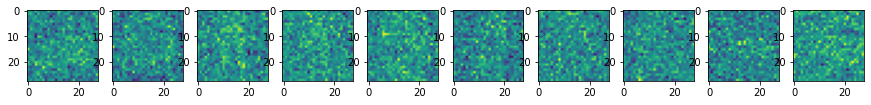

<Figure size 432x288 with 0 Axes>

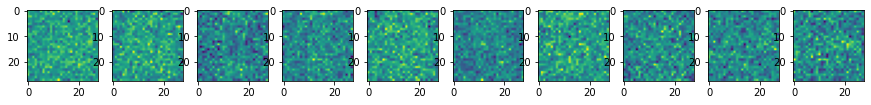

<Figure size 432x288 with 0 Axes>

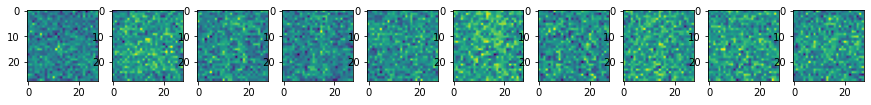

<Figure size 432x288 with 0 Axes>

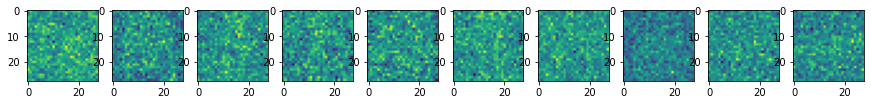

<Figure size 432x288 with 0 Axes>

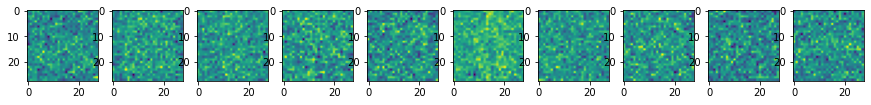

<Figure size 432x288 with 0 Axes>

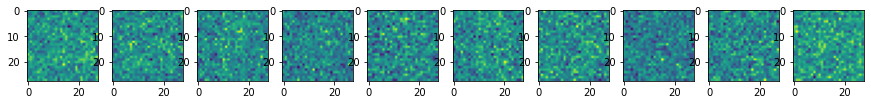

<Figure size 432x288 with 0 Axes>

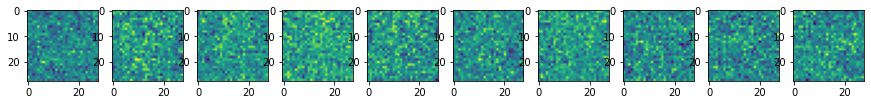

<Figure size 432x288 with 0 Axes>

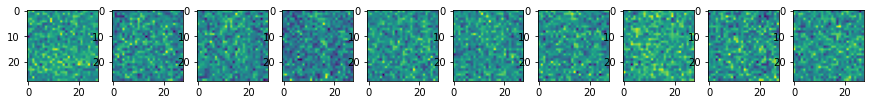

In [4]:
#Display clean data
print("Clean Data")
display_images(images_testing)

print("Noisy Data")
sd_test = np.arange(0.1,2,0.1)
for i in range(len(sd_test)):
    noisy_testing = generate_gaussian_noise(images_testing,sd_test[i])
    
    display_images(noisy_testing)
  

Contrast Data


<Figure size 432x288 with 0 Axes>

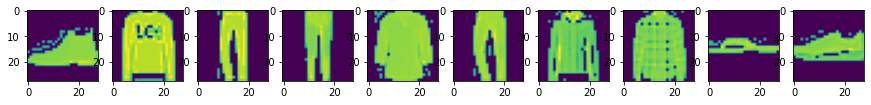

<Figure size 432x288 with 0 Axes>

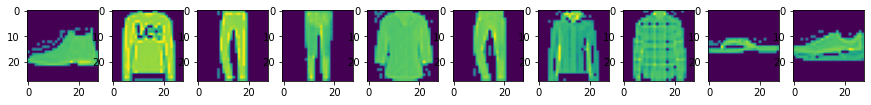

<Figure size 432x288 with 0 Axes>

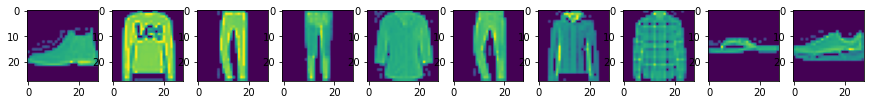

<Figure size 432x288 with 0 Axes>

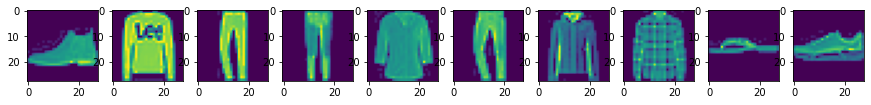

<Figure size 432x288 with 0 Axes>

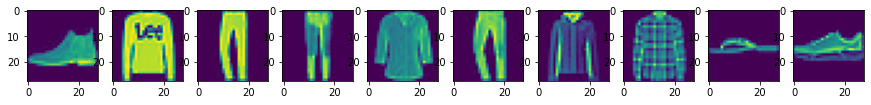

<Figure size 432x288 with 0 Axes>

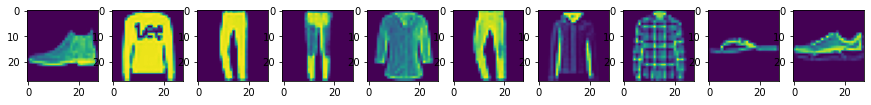

<Figure size 432x288 with 0 Axes>

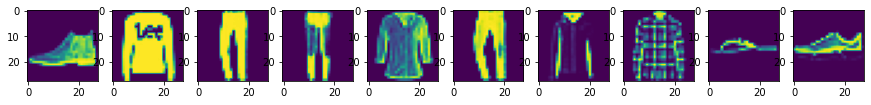

<Figure size 432x288 with 0 Axes>

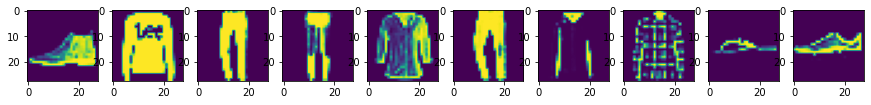

In [5]:
#Display contrast data


print("Contrast Data")
cn_test = [0.05, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4]
for i in range(len(cn_test)):
    noisy_testing = generate_contrast(images_testing,cn_test[i])
    
    display_images(noisy_testing)
  

In [6]:
print("Dropout Data")
sd_test = np.arange(0,1,0.1)
for i in range(len(sd_test)):
    noisy_testing = generate_pixel_dropout(images_testing,sd_test[i])
    
    display_images(noisy_testing)

Dropout Data


KeyboardInterrupt: 

# No noise in training

In [24]:
#Train standard feedforward model

images_training_flat = images_training.reshape(np.shape(images_training)[0],784)

inputs = Input(shape=(784))
layer = Dense(10,activation='relu')(inputs)


outputs = Dense(10,activation='softmax')(layer)

model_feedforward = Model(inputs=inputs,outputs=outputs)

model_feedforward_intermed = Model(inputs=inputs,outputs=layer)

model_feedforward.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_feedforward.fit(images_training_flat,labels_training,batch_size=100,verbose = 0, epochs=500,validation_split=0.33,callbacks=[es])


Epoch 44: early stopping


313/313 [==============================] - 0s 539us/step


<Figure size 432x288 with 0 Axes>

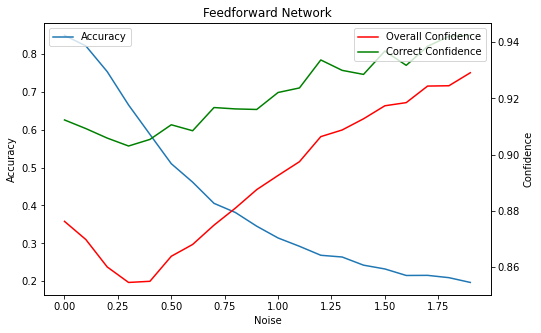

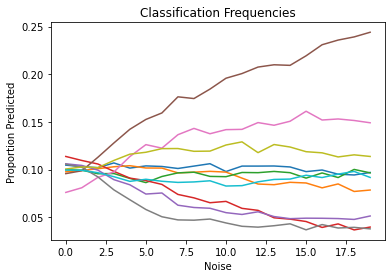

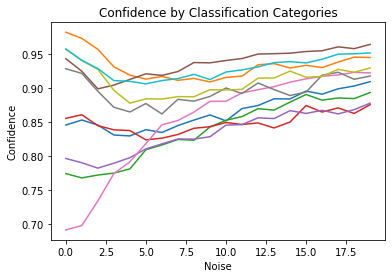

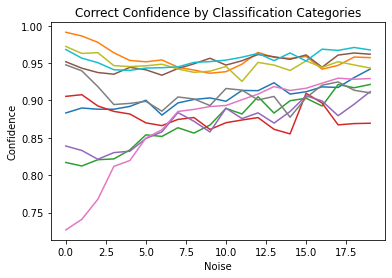

<Figure size 432x288 with 0 Axes>

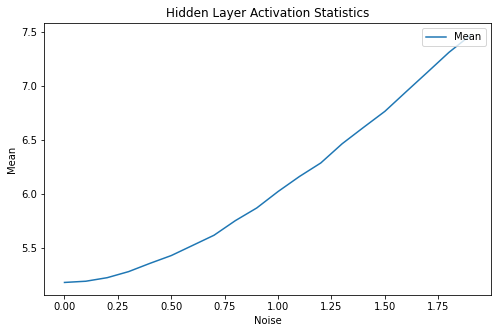

In [8]:
# Vary noise


sd_test = np.arange(0,2,.1)

all_conf_array = []
correct_conf_array = []
acc_array = []

conf_cat_all_array = np.empty((10,0))
conf_cat_correct_array = np.empty((10,0))
freq_all = np.empty((10,0))

activation_mean = []

for i in range(len(sd_test)):
    images_testing_noise = generate_gaussian_noise(images_testing,sd_test[i])
    images_testing_noise_flat = images_testing_noise.reshape(np.shape(images_testing_noise)[0],784)
    labels_testing_predicted = model_feedforward.predict(images_testing_noise_flat)
    
    all_conf,correct_conf = compute_confidence(labels_testing,labels_testing_predicted)
    acc = compute_accuracy(labels_testing,labels_testing_predicted)
    
    all_conf_array.append(all_conf)
    correct_conf_array.append(correct_conf)   
    acc_array.append(acc)
    
    freq = compute_frequencies(labels_testing_predicted)
    
    freq_all = np.hstack((freq_all,freq))
    
    conf_cat_all, conf_cat_correct = compute_confidence_by_category(labels_testing,labels_testing_predicted)
    

    
    conf_cat_all_array = np.hstack((conf_cat_all_array,conf_cat_all))
    conf_cat_correct_array = np.hstack((conf_cat_correct_array,conf_cat_correct))
    
    
    hidden_activation = model_feedforward_intermed.predict(images_testing_noise_flat)
    
    activation_mean.append(np.mean(hidden_activation))

plt.figure(1)
fig, acc_ax = plt.subplots(figsize=(8,5))
conf_ax = acc_ax.twinx()
acc_ax.set_xlabel("Noise")
acc_ax.set_ylabel("Accuracy")
conf_ax.set_ylabel("Confidence")
acc_ax.plot(sd_test,acc_array, label = "Accuracy")
conf_ax.plot(sd_test,all_conf_array, label = "Overall Confidence",color='r')
conf_ax.plot(sd_test,correct_conf_array, label = "Correct Confidence",color='g')
plt.title("Feedforward Network")
conf_ax.legend(loc= "upper right")
acc_ax.legend(loc= "upper left")
plt.show()

plt.figure(2)
for i in range(10):
    plt.plot(freq_all[i,:])

plt.xlabel("Noise")
plt.ylabel("Proportion Predicted")
plt.title("Classification Frequencies")
plt.show()

plt.figure(3)
for i in range(10):
    plt.plot(conf_cat_all_array[i,:])

plt.xlabel("Noise")
plt.ylabel("Confidence")
plt.title("Confidence by Classification Categories")
plt.show()

plt.figure(4)
for i in range(10):
    plt.plot(conf_cat_correct_array[i,:])

plt.xlabel("Noise")
plt.ylabel("Confidence")
plt.title("Correct Confidence by Classification Categories")
plt.show()


plt.figure(5)
fig, mean_ax = plt.subplots(figsize=(8,5))
#var_ax = mean_ax.twinx()
mean_ax.set_xlabel("Noise")
mean_ax.set_ylabel("Mean")
#var_ax.set_ylabel("Variance")
mean_ax.plot(sd_test,activation_mean, label = "Mean")
#var_ax.plot(sd_test,activation_var, label = "Var",color='r')
plt.title("Hidden Layer Activation Statistics")
mean_ax.legend(loc= "upper right")
#var_ax.legend(loc= "upper left")
plt.show()

  1/313 [..............................] - ETA: 3s

C:\Users\samue\AppData\Local\Temp\ipykernel_33264\1708496032.py:124: RuntimeWarning: invalid value encountered in true_divide
  all_conf[j] = all_conf[j]/cc[j]
C:\Users\samue\AppData\Local\Temp\ipykernel_33264\1708496032.py:125: RuntimeWarning: invalid value encountered in true_divide
  correct_conf[j] = correct_conf[j]/c[j]


313/313 [==============================] - 0s 599us/step


<Figure size 432x288 with 0 Axes>

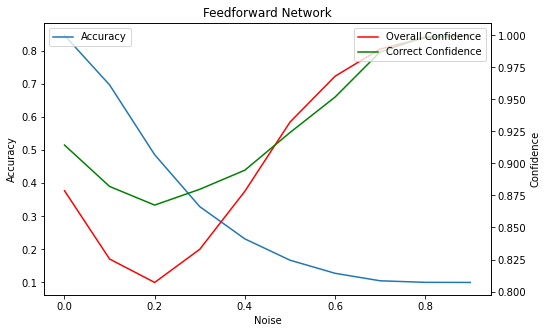

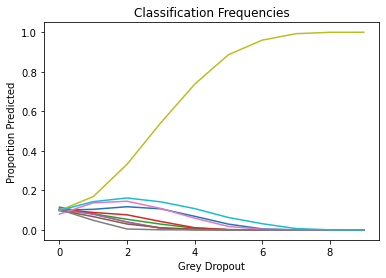

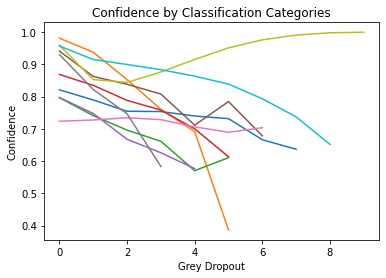

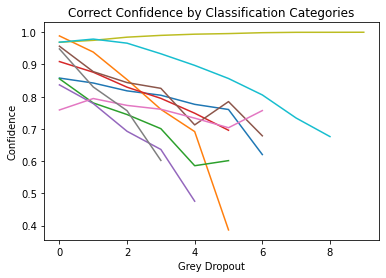

<Figure size 432x288 with 0 Axes>

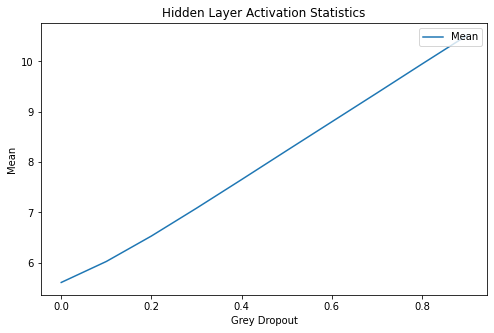

In [25]:
# Vary grey dropout


sd_test = np.arange(0,1,.1)

all_conf_array = []
correct_conf_array = []
acc_array = []

conf_cat_all_array = np.empty((10,0))
conf_cat_correct_array = np.empty((10,0))
freq_all = np.empty((10,0))

activation_mean = []

for i in range(len(sd_test)):
    images_testing_noise = generate_pixel_dropout(images_testing,sd_test[i],0.5)
    images_testing_noise_flat = images_testing_noise.reshape(np.shape(images_testing_noise)[0],784)
    labels_testing_predicted = model_feedforward.predict(images_testing_noise_flat)
    
    all_conf,correct_conf = compute_confidence(labels_testing,labels_testing_predicted)
    acc = compute_accuracy(labels_testing,labels_testing_predicted)
    
    all_conf_array.append(all_conf)
    correct_conf_array.append(correct_conf)   
    acc_array.append(acc)
    
    freq = compute_frequencies(labels_testing_predicted)
    
    freq_all = np.hstack((freq_all,freq))
    
    conf_cat_all, conf_cat_correct = compute_confidence_by_category(labels_testing,labels_testing_predicted)
    

    
    conf_cat_all_array = np.hstack((conf_cat_all_array,conf_cat_all))
    conf_cat_correct_array = np.hstack((conf_cat_correct_array,conf_cat_correct))
    
    
    hidden_activation = model_feedforward_intermed.predict(images_testing_noise_flat)
    
    activation_mean.append(np.mean(hidden_activation))

plt.figure(1)
fig, acc_ax = plt.subplots(figsize=(8,5))
conf_ax = acc_ax.twinx()
acc_ax.set_xlabel("Noise")
acc_ax.set_ylabel("Accuracy")
conf_ax.set_ylabel("Confidence")
acc_ax.plot(sd_test,acc_array, label = "Accuracy")
conf_ax.plot(sd_test,all_conf_array, label = "Overall Confidence",color='r')
conf_ax.plot(sd_test,correct_conf_array, label = "Correct Confidence",color='g')
plt.title("Feedforward Network")
conf_ax.legend(loc= "upper right")
acc_ax.legend(loc= "upper left")
plt.show()

plt.figure(2)
for i in range(10):
    plt.plot(freq_all[i,:])

plt.xlabel("Grey Dropout")
plt.ylabel("Proportion Predicted")
plt.title("Classification Frequencies")
plt.show()

plt.figure(3)
for i in range(10):
    plt.plot(conf_cat_all_array[i,:])

plt.xlabel("Grey Dropout")
plt.ylabel("Confidence")
plt.title("Confidence by Classification Categories")
plt.show()

plt.figure(4)
for i in range(10):
    plt.plot(conf_cat_correct_array[i,:])

plt.xlabel("Grey Dropout")
plt.ylabel("Confidence")
plt.title("Correct Confidence by Classification Categories")
plt.show()


plt.figure(5)
fig, mean_ax = plt.subplots(figsize=(8,5))
#var_ax = mean_ax.twinx()
mean_ax.set_xlabel("Grey Dropout")
mean_ax.set_ylabel("Mean")
#var_ax.set_ylabel("Variance")
mean_ax.plot(sd_test,activation_mean, label = "Mean")
#var_ax.plot(sd_test,activation_var, label = "Var",color='r')
plt.title("Hidden Layer Activation Statistics")
mean_ax.legend(loc= "upper right")
#var_ax.legend(loc= "upper left")
plt.show()

# Up to 0.3 noise in training

In [9]:
#Train standard feedforward model

noise_sd = 0.3

images_training_noise = generate_gaussian_noise_range(images_training,noise_sd)

images_training_flat = images_training_noise.reshape(np.shape(images_training)[0],784)

inputs = Input(shape=(784))
layer = Dense(10,activation='relu')(inputs)


outputs = Dense(10,activation='softmax')(layer)

model_feedforward = Model(inputs=inputs,outputs=outputs)

model_feedforward_intermed = Model(inputs=inputs,outputs=layer)

model_feedforward.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_feedforward.fit(images_training_flat,labels_training,batch_size=100,verbose = 0, epochs=500,validation_split=0.33,callbacks=[es])


Epoch 19: early stopping


313/313 [==============================] - 0s 549us/step


<Figure size 432x288 with 0 Axes>

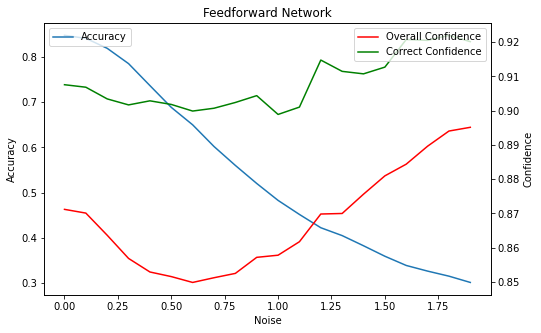

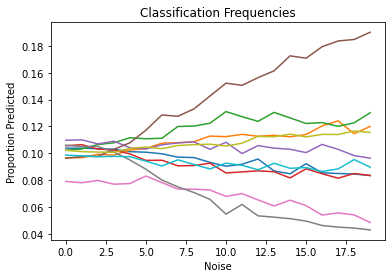

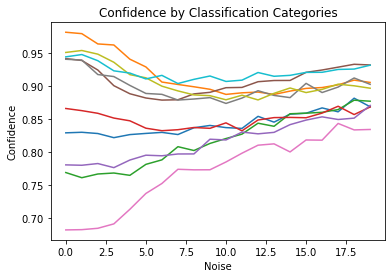

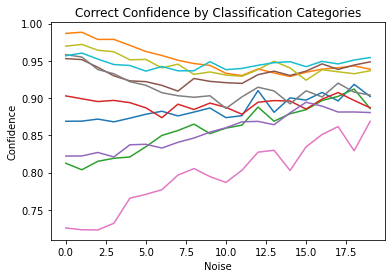

<Figure size 432x288 with 0 Axes>

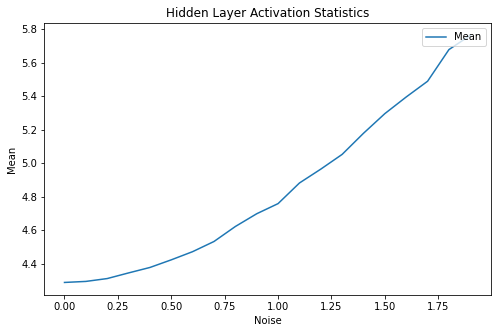

In [10]:
# Vary noise


sd_test = np.arange(0,2,.1)

all_conf_array = []
correct_conf_array = []
acc_array = []

conf_cat_all_array = np.empty((10,0))
conf_cat_correct_array = np.empty((10,0))
freq_all = np.empty((10,0))

activation_mean = []

for i in range(len(sd_test)):
    images_testing_noise = generate_gaussian_noise(images_testing,sd_test[i])
    images_testing_noise_flat = images_testing_noise.reshape(np.shape(images_testing_noise)[0],784)
    labels_testing_predicted = model_feedforward.predict(images_testing_noise_flat)
    
    all_conf,correct_conf = compute_confidence(labels_testing,labels_testing_predicted)
    acc = compute_accuracy(labels_testing,labels_testing_predicted)
    
    all_conf_array.append(all_conf)
    correct_conf_array.append(correct_conf)   
    acc_array.append(acc)
    
    freq = compute_frequencies(labels_testing_predicted)
    
    freq_all = np.hstack((freq_all,freq))
    
    conf_cat_all, conf_cat_correct = compute_confidence_by_category(labels_testing,labels_testing_predicted)
    

    
    conf_cat_all_array = np.hstack((conf_cat_all_array,conf_cat_all))
    conf_cat_correct_array = np.hstack((conf_cat_correct_array,conf_cat_correct))
    
    
    hidden_activation = model_feedforward_intermed.predict(images_testing_noise_flat)
    
    activation_mean.append(np.mean(hidden_activation))

plt.figure(1)
fig, acc_ax = plt.subplots(figsize=(8,5))
conf_ax = acc_ax.twinx()
acc_ax.set_xlabel("Noise")
acc_ax.set_ylabel("Accuracy")
conf_ax.set_ylabel("Confidence")
acc_ax.plot(sd_test,acc_array, label = "Accuracy")
conf_ax.plot(sd_test,all_conf_array, label = "Overall Confidence",color='r')
conf_ax.plot(sd_test,correct_conf_array, label = "Correct Confidence",color='g')
plt.title("Feedforward Network")
conf_ax.legend(loc= "upper right")
acc_ax.legend(loc= "upper left")
plt.show()

plt.figure(2)
for i in range(10):
    plt.plot(freq_all[i,:])

plt.xlabel("Noise")
plt.ylabel("Proportion Predicted")
plt.title("Classification Frequencies")
plt.show()

plt.figure(3)
for i in range(10):
    plt.plot(conf_cat_all_array[i,:])

plt.xlabel("Noise")
plt.ylabel("Confidence")
plt.title("Confidence by Classification Categories")
plt.show()

plt.figure(4)
for i in range(10):
    plt.plot(conf_cat_correct_array[i,:])

plt.xlabel("Noise")
plt.ylabel("Confidence")
plt.title("Correct Confidence by Classification Categories")
plt.show()


plt.figure(5)
fig, mean_ax = plt.subplots(figsize=(8,5))
#var_ax = mean_ax.twinx()
mean_ax.set_xlabel("Noise")
mean_ax.set_ylabel("Mean")
#var_ax.set_ylabel("Variance")
mean_ax.plot(sd_test,activation_mean, label = "Mean")
#var_ax.plot(sd_test,activation_var, label = "Var",color='r')
plt.title("Hidden Layer Activation Statistics")
mean_ax.legend(loc= "upper right")
#var_ax.legend(loc= "upper left")
plt.show()

# Up to 0.8 noise in training

In [11]:
#Train standard feedforward model

noise_sd = 0.8

images_training_noise = generate_gaussian_noise_range(images_training,noise_sd)

images_training_flat = images_training_noise.reshape(np.shape(images_training)[0],784)

inputs = Input(shape=(784))
layer = Dense(10,activation='relu')(inputs)


outputs = Dense(10,activation='softmax')(layer)

model_feedforward = Model(inputs=inputs,outputs=outputs)

model_feedforward_intermed = Model(inputs=inputs,outputs=layer)

model_feedforward.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_feedforward.fit(images_training_flat,labels_training,batch_size=100,verbose = 0, epochs=500,validation_split=0.33,callbacks=[es])


Epoch 17: early stopping


313/313 [==============================] - 0s 549us/step


<Figure size 432x288 with 0 Axes>

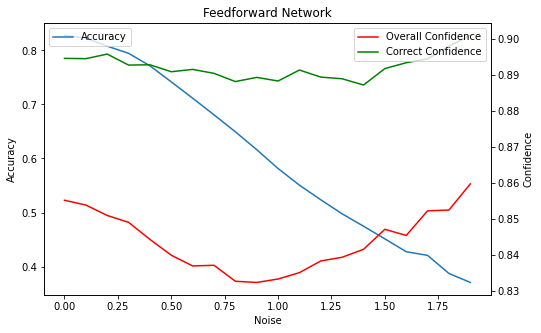

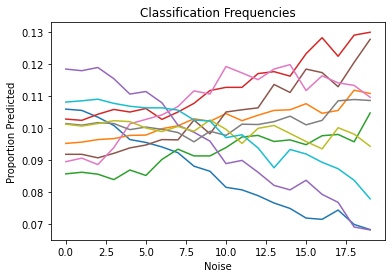

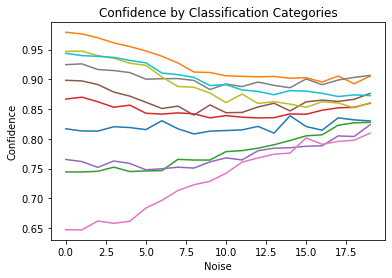

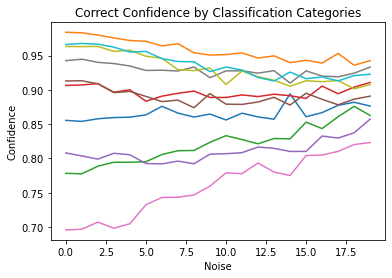

<Figure size 432x288 with 0 Axes>

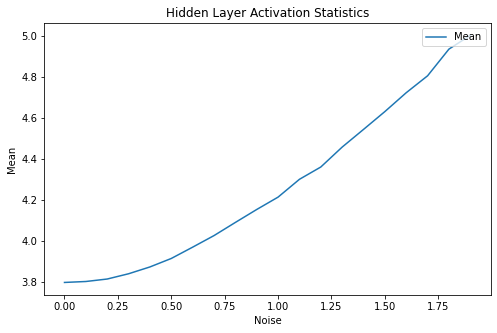

In [12]:
# Vary noise


sd_test = np.arange(0,2,.1)

all_conf_array = []
correct_conf_array = []
acc_array = []

conf_cat_all_array = np.empty((10,0))
conf_cat_correct_array = np.empty((10,0))
freq_all = np.empty((10,0))

activation_mean = []

for i in range(len(sd_test)):
    images_testing_noise = generate_gaussian_noise(images_testing,sd_test[i])
    images_testing_noise_flat = images_testing_noise.reshape(np.shape(images_testing_noise)[0],784)
    labels_testing_predicted = model_feedforward.predict(images_testing_noise_flat)
    
    all_conf,correct_conf = compute_confidence(labels_testing,labels_testing_predicted)
    acc = compute_accuracy(labels_testing,labels_testing_predicted)
    
    all_conf_array.append(all_conf)
    correct_conf_array.append(correct_conf)   
    acc_array.append(acc)
    
    freq = compute_frequencies(labels_testing_predicted)
    
    freq_all = np.hstack((freq_all,freq))
    
    conf_cat_all, conf_cat_correct = compute_confidence_by_category(labels_testing,labels_testing_predicted)
    

    
    conf_cat_all_array = np.hstack((conf_cat_all_array,conf_cat_all))
    conf_cat_correct_array = np.hstack((conf_cat_correct_array,conf_cat_correct))
    
    
    hidden_activation = model_feedforward_intermed.predict(images_testing_noise_flat)
    
    activation_mean.append(np.mean(hidden_activation))

plt.figure(1)
fig, acc_ax = plt.subplots(figsize=(8,5))
conf_ax = acc_ax.twinx()
acc_ax.set_xlabel("Noise")
acc_ax.set_ylabel("Accuracy")
conf_ax.set_ylabel("Confidence")
acc_ax.plot(sd_test,acc_array, label = "Accuracy")
conf_ax.plot(sd_test,all_conf_array, label = "Overall Confidence",color='r')
conf_ax.plot(sd_test,correct_conf_array, label = "Correct Confidence",color='g')
plt.title("Feedforward Network")
conf_ax.legend(loc= "upper right")
acc_ax.legend(loc= "upper left")
plt.show()

plt.figure(2)
for i in range(10):
    plt.plot(freq_all[i,:])

plt.xlabel("Noise")
plt.ylabel("Proportion Predicted")
plt.title("Classification Frequencies")
plt.show()

plt.figure(3)
for i in range(10):
    plt.plot(conf_cat_all_array[i,:])

plt.xlabel("Noise")
plt.ylabel("Confidence")
plt.title("Confidence by Classification Categories")
plt.show()

plt.figure(4)
for i in range(10):
    plt.plot(conf_cat_correct_array[i,:])

plt.xlabel("Noise")
plt.ylabel("Confidence")
plt.title("Correct Confidence by Classification Categories")
plt.show()


plt.figure(5)
fig, mean_ax = plt.subplots(figsize=(8,5))
#var_ax = mean_ax.twinx()
mean_ax.set_xlabel("Noise")
mean_ax.set_ylabel("Mean")
#var_ax.set_ylabel("Variance")
mean_ax.plot(sd_test,activation_mean, label = "Mean")
#var_ax.plot(sd_test,activation_var, label = "Var",color='r')
plt.title("Hidden Layer Activation Statistics")
mean_ax.legend(loc= "upper right")
#var_ax.legend(loc= "upper left")
plt.show()

# Train on gaussian noise, test on grey dropout

In [13]:
#Train standard feedforward model

noise_sd = 0.8

images_training_noise = generate_gaussian_noise_range(images_training,noise_sd)

images_training_flat = images_training_noise.reshape(np.shape(images_training)[0],784)

inputs = Input(shape=(784))
layer = Dense(10,activation='relu')(inputs)


outputs = Dense(10,activation='softmax')(layer)

model_feedforward = Model(inputs=inputs,outputs=outputs)

model_feedforward_intermed = Model(inputs=inputs,outputs=layer)

model_feedforward.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_feedforward.fit(images_training_flat,labels_training,batch_size=100,verbose = 0, epochs=500,validation_split=0.33,callbacks=[es])


Epoch 15: early stopping


  1/313 [..............................] - ETA: 3s

C:\Users\samue\AppData\Local\Temp\ipykernel_33264\3071693690.py:125: RuntimeWarning: invalid value encountered in true_divide
  correct_conf[j] = correct_conf[j]/c[j]
C:\Users\samue\AppData\Local\Temp\ipykernel_33264\3071693690.py:124: RuntimeWarning: invalid value encountered in true_divide
  all_conf[j] = all_conf[j]/cc[j]


313/313 [==============================] - 0s 538us/step


<Figure size 432x288 with 0 Axes>

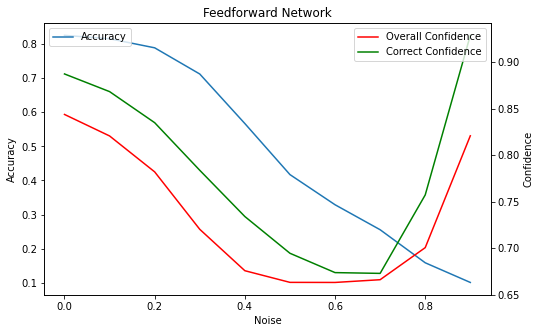

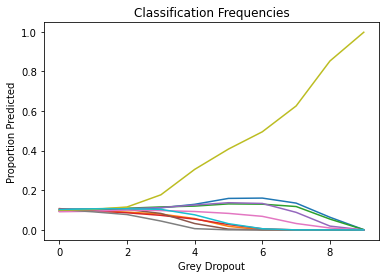

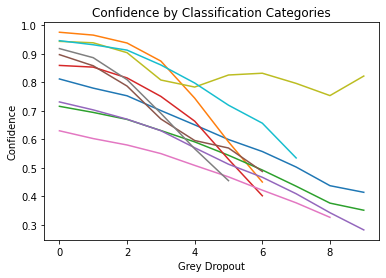

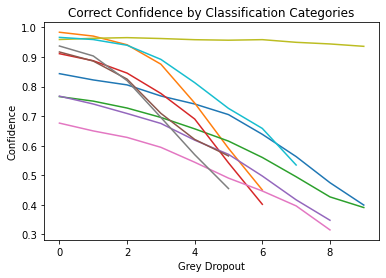

<Figure size 432x288 with 0 Axes>

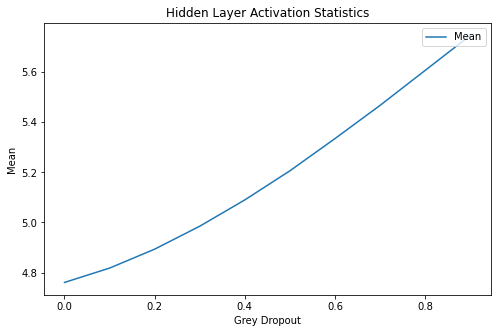

In [14]:
# Vary grey dropout


sd_test = np.arange(0,1,.1)

all_conf_array = []
correct_conf_array = []
acc_array = []

conf_cat_all_array = np.empty((10,0))
conf_cat_correct_array = np.empty((10,0))
freq_all = np.empty((10,0))

activation_mean = []

for i in range(len(sd_test)):
    images_testing_noise = generate_pixel_dropout(images_testing,sd_test[i],0.5)
    images_testing_noise_flat = images_testing_noise.reshape(np.shape(images_testing_noise)[0],784)
    labels_testing_predicted = model_feedforward.predict(images_testing_noise_flat)
    
    all_conf,correct_conf = compute_confidence(labels_testing,labels_testing_predicted)
    acc = compute_accuracy(labels_testing,labels_testing_predicted)
    
    all_conf_array.append(all_conf)
    correct_conf_array.append(correct_conf)   
    acc_array.append(acc)
    
    freq = compute_frequencies(labels_testing_predicted)
    
    freq_all = np.hstack((freq_all,freq))
    
    conf_cat_all, conf_cat_correct = compute_confidence_by_category(labels_testing,labels_testing_predicted)
    

    
    conf_cat_all_array = np.hstack((conf_cat_all_array,conf_cat_all))
    conf_cat_correct_array = np.hstack((conf_cat_correct_array,conf_cat_correct))
    
    
    hidden_activation = model_feedforward_intermed.predict(images_testing_noise_flat)
    
    activation_mean.append(np.mean(hidden_activation))

plt.figure(1)
fig, acc_ax = plt.subplots(figsize=(8,5))
conf_ax = acc_ax.twinx()
acc_ax.set_xlabel("Noise")
acc_ax.set_ylabel("Accuracy")
conf_ax.set_ylabel("Confidence")
acc_ax.plot(sd_test,acc_array, label = "Accuracy")
conf_ax.plot(sd_test,all_conf_array, label = "Overall Confidence",color='r')
conf_ax.plot(sd_test,correct_conf_array, label = "Correct Confidence",color='g')
plt.title("Feedforward Network")
conf_ax.legend(loc= "upper right")
acc_ax.legend(loc= "upper left")
plt.show()

plt.figure(2)
for i in range(10):
    plt.plot(freq_all[i,:])

plt.xlabel("Grey Dropout")
plt.ylabel("Proportion Predicted")
plt.title("Classification Frequencies")
plt.show()

plt.figure(3)
for i in range(10):
    plt.plot(conf_cat_all_array[i,:])

plt.xlabel("Grey Dropout")
plt.ylabel("Confidence")
plt.title("Confidence by Classification Categories")
plt.show()

plt.figure(4)
for i in range(10):
    plt.plot(conf_cat_correct_array[i,:])

plt.xlabel("Grey Dropout")
plt.ylabel("Confidence")
plt.title("Correct Confidence by Classification Categories")
plt.show()


plt.figure(5)
fig, mean_ax = plt.subplots(figsize=(8,5))
#var_ax = mean_ax.twinx()
mean_ax.set_xlabel("Grey Dropout")
mean_ax.set_ylabel("Mean")
#var_ax.set_ylabel("Variance")
mean_ax.plot(sd_test,activation_mean, label = "Mean")
#var_ax.plot(sd_test,activation_var, label = "Var",color='r')
plt.title("Hidden Layer Activation Statistics")
mean_ax.legend(loc= "upper right")
#var_ax.legend(loc= "upper left")
plt.show()

In [22]:
#Train standard feedforward model

noise_sd = 0.3

images_training_noise = generate_gaussian_noise_range(images_training,noise_sd)

images_training_flat = images_training_noise.reshape(np.shape(images_training)[0],784)

inputs = Input(shape=(784))
layer = Dense(10,activation='relu')(inputs)


outputs = Dense(10,activation='softmax')(layer)

model_feedforward = Model(inputs=inputs,outputs=outputs)

model_feedforward_intermed = Model(inputs=inputs,outputs=layer)

model_feedforward.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_feedforward.fit(images_training_flat,labels_training,batch_size=100,verbose = 0, epochs=500,validation_split=0.33,callbacks=[es])


Epoch 21: early stopping


 96/313 [========>.....................] - ETA: 0s

C:\Users\samue\AppData\Local\Temp\ipykernel_33264\1708496032.py:125: RuntimeWarning: invalid value encountered in true_divide
  correct_conf[j] = correct_conf[j]/c[j]


  1/313 [..............................] - ETA: 3s

C:\Users\samue\AppData\Local\Temp\ipykernel_33264\1708496032.py:124: RuntimeWarning: invalid value encountered in true_divide
  all_conf[j] = all_conf[j]/cc[j]


313/313 [==============================] - 0s 526us/step


<Figure size 432x288 with 0 Axes>

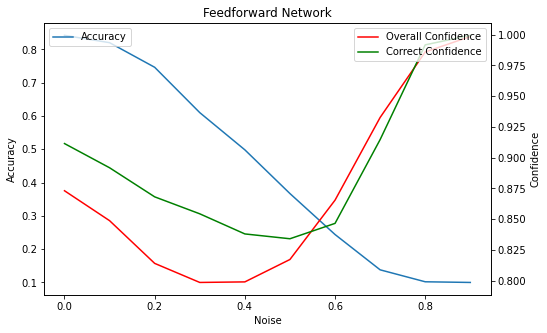

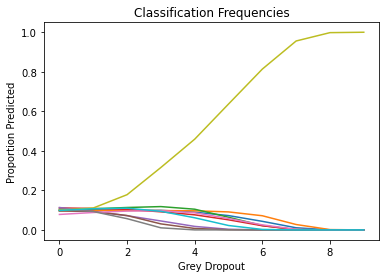

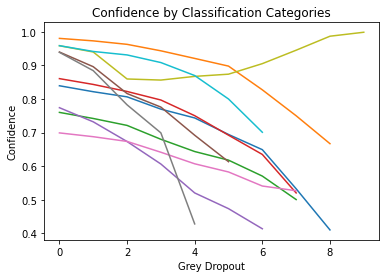

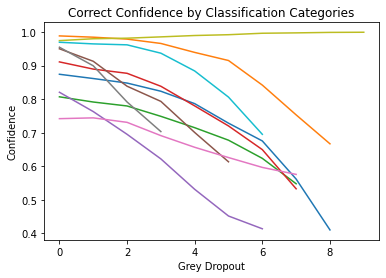

<Figure size 432x288 with 0 Axes>

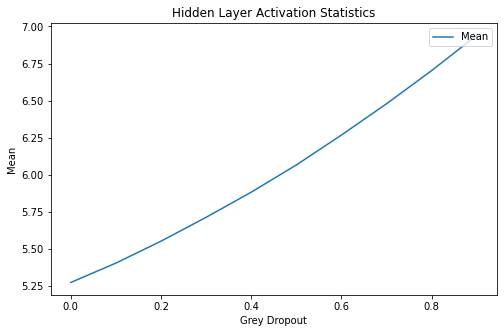

In [23]:
# Vary grey dropout


sd_test = np.arange(0,1,.1)

all_conf_array = []
correct_conf_array = []
acc_array = []

conf_cat_all_array = np.empty((10,0))
conf_cat_correct_array = np.empty((10,0))
freq_all = np.empty((10,0))

activation_mean = []

for i in range(len(sd_test)):
    images_testing_noise = generate_pixel_dropout(images_testing,sd_test[i],0.5)
    images_testing_noise_flat = images_testing_noise.reshape(np.shape(images_testing_noise)[0],784)
    labels_testing_predicted = model_feedforward.predict(images_testing_noise_flat)
    
    all_conf,correct_conf = compute_confidence(labels_testing,labels_testing_predicted)
    acc = compute_accuracy(labels_testing,labels_testing_predicted)
    
    all_conf_array.append(all_conf)
    correct_conf_array.append(correct_conf)   
    acc_array.append(acc)
    
    freq = compute_frequencies(labels_testing_predicted)
    
    freq_all = np.hstack((freq_all,freq))
    
    conf_cat_all, conf_cat_correct = compute_confidence_by_category(labels_testing,labels_testing_predicted)
    

    
    conf_cat_all_array = np.hstack((conf_cat_all_array,conf_cat_all))
    conf_cat_correct_array = np.hstack((conf_cat_correct_array,conf_cat_correct))
    
    
    hidden_activation = model_feedforward_intermed.predict(images_testing_noise_flat)
    
    activation_mean.append(np.mean(hidden_activation))

plt.figure(1)
fig, acc_ax = plt.subplots(figsize=(8,5))
conf_ax = acc_ax.twinx()
acc_ax.set_xlabel("Noise")
acc_ax.set_ylabel("Accuracy")
conf_ax.set_ylabel("Confidence")
acc_ax.plot(sd_test,acc_array, label = "Accuracy")
conf_ax.plot(sd_test,all_conf_array, label = "Overall Confidence",color='r')
conf_ax.plot(sd_test,correct_conf_array, label = "Correct Confidence",color='g')
plt.title("Feedforward Network")
conf_ax.legend(loc= "upper right")
acc_ax.legend(loc= "upper left")
plt.show()

plt.figure(2)
for i in range(10):
    plt.plot(freq_all[i,:])

plt.xlabel("Grey Dropout")
plt.ylabel("Proportion Predicted")
plt.title("Classification Frequencies")
plt.show()

plt.figure(3)
for i in range(10):
    plt.plot(conf_cat_all_array[i,:])

plt.xlabel("Grey Dropout")
plt.ylabel("Confidence")
plt.title("Confidence by Classification Categories")
plt.show()

plt.figure(4)
for i in range(10):
    plt.plot(conf_cat_correct_array[i,:])

plt.xlabel("Grey Dropout")
plt.ylabel("Confidence")
plt.title("Correct Confidence by Classification Categories")
plt.show()


plt.figure(5)
fig, mean_ax = plt.subplots(figsize=(8,5))
#var_ax = mean_ax.twinx()
mean_ax.set_xlabel("Grey Dropout")
mean_ax.set_ylabel("Mean")
#var_ax.set_ylabel("Variance")
mean_ax.plot(sd_test,activation_mean, label = "Mean")
#var_ax.plot(sd_test,activation_var, label = "Var",color='r')
plt.title("Hidden Layer Activation Statistics")
mean_ax.legend(loc= "upper right")
#var_ax.legend(loc= "upper left")
plt.show()

# Train on grey noise, test on grey dropout

In [26]:
#Train standard feedforward model

dropout_level = 0.8

images_training_noise = generate_dropout_pixel_range(images_training,dropout_level)

images_training_flat = images_training_noise.reshape(np.shape(images_training)[0],784)

inputs = Input(shape=(784))
layer = Dense(10,activation='relu')(inputs)


outputs = Dense(10,activation='softmax')(layer)

model_feedforward = Model(inputs=inputs,outputs=outputs)

model_feedforward_intermed = Model(inputs=inputs,outputs=layer)

model_feedforward.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_feedforward.fit(images_training_flat,labels_training,batch_size=100,verbose = 0, epochs=500,validation_split=0.33,callbacks=[es])


Epoch 24: early stopping


313/313 [==============================] - 0s 521us/step


<Figure size 432x288 with 0 Axes>

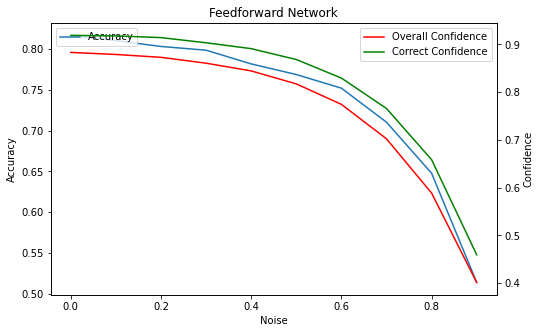

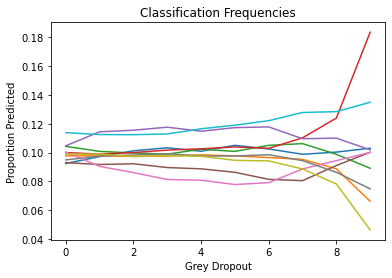

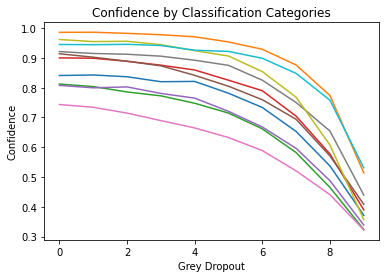

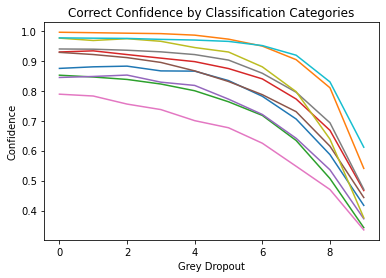

<Figure size 432x288 with 0 Axes>

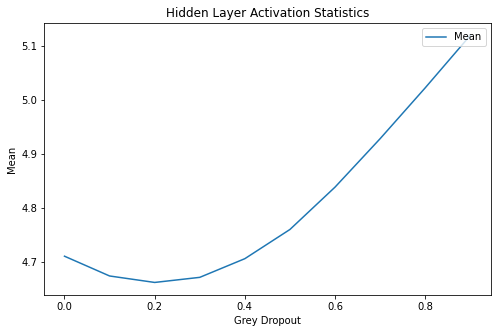

In [27]:
# Vary grey dropout


sd_test = np.arange(0,1,.1)

all_conf_array = []
correct_conf_array = []
acc_array = []

conf_cat_all_array = np.empty((10,0))
conf_cat_correct_array = np.empty((10,0))
freq_all = np.empty((10,0))

activation_mean = []

for i in range(len(sd_test)):
    images_testing_noise = generate_pixel_dropout(images_testing,sd_test[i],0.5)
    images_testing_noise_flat = images_testing_noise.reshape(np.shape(images_testing_noise)[0],784)
    labels_testing_predicted = model_feedforward.predict(images_testing_noise_flat)
    
    all_conf,correct_conf = compute_confidence(labels_testing,labels_testing_predicted)
    acc = compute_accuracy(labels_testing,labels_testing_predicted)
    
    all_conf_array.append(all_conf)
    correct_conf_array.append(correct_conf)   
    acc_array.append(acc)
    
    freq = compute_frequencies(labels_testing_predicted)
    
    freq_all = np.hstack((freq_all,freq))
    
    conf_cat_all, conf_cat_correct = compute_confidence_by_category(labels_testing,labels_testing_predicted)
    

    
    conf_cat_all_array = np.hstack((conf_cat_all_array,conf_cat_all))
    conf_cat_correct_array = np.hstack((conf_cat_correct_array,conf_cat_correct))
    
    
    hidden_activation = model_feedforward_intermed.predict(images_testing_noise_flat)
    
    activation_mean.append(np.mean(hidden_activation))

plt.figure(1)
fig, acc_ax = plt.subplots(figsize=(8,5))
conf_ax = acc_ax.twinx()
acc_ax.set_xlabel("Noise")
acc_ax.set_ylabel("Accuracy")
conf_ax.set_ylabel("Confidence")
acc_ax.plot(sd_test,acc_array, label = "Accuracy")
conf_ax.plot(sd_test,all_conf_array, label = "Overall Confidence",color='r')
conf_ax.plot(sd_test,correct_conf_array, label = "Correct Confidence",color='g')
plt.title("Feedforward Network")
conf_ax.legend(loc= "upper right")
acc_ax.legend(loc= "upper left")
plt.show()

plt.figure(2)
for i in range(10):
    plt.plot(freq_all[i,:])

plt.xlabel("Grey Dropout")
plt.ylabel("Proportion Predicted")
plt.title("Classification Frequencies")
plt.show()

plt.figure(3)
for i in range(10):
    plt.plot(conf_cat_all_array[i,:])

plt.xlabel("Grey Dropout")
plt.ylabel("Confidence")
plt.title("Confidence by Classification Categories")
plt.show()

plt.figure(4)
for i in range(10):
    plt.plot(conf_cat_correct_array[i,:])

plt.xlabel("Grey Dropout")
plt.ylabel("Confidence")
plt.title("Correct Confidence by Classification Categories")
plt.show()


plt.figure(5)
fig, mean_ax = plt.subplots(figsize=(8,5))
#var_ax = mean_ax.twinx()
mean_ax.set_xlabel("Grey Dropout")
mean_ax.set_ylabel("Mean")
#var_ax.set_ylabel("Variance")
mean_ax.plot(sd_test,activation_mean, label = "Mean")
#var_ax.plot(sd_test,activation_var, label = "Var",color='r')
plt.title("Hidden Layer Activation Statistics")
mean_ax.legend(loc= "upper right")
#var_ax.legend(loc= "upper left")
plt.show()

313/313 [==============================] - 0s 535us/step


<Figure size 432x288 with 0 Axes>

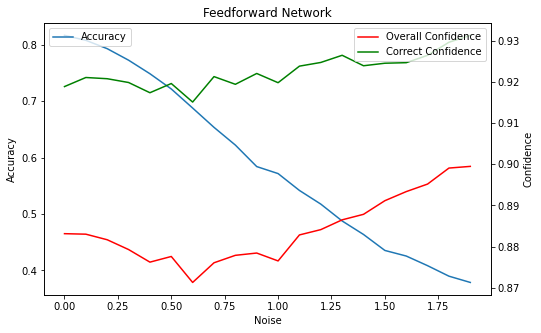

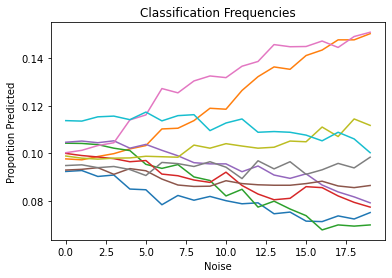

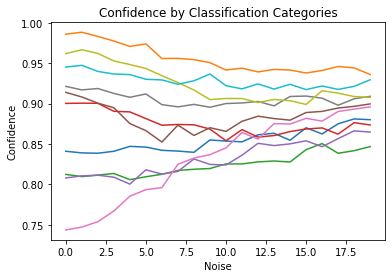

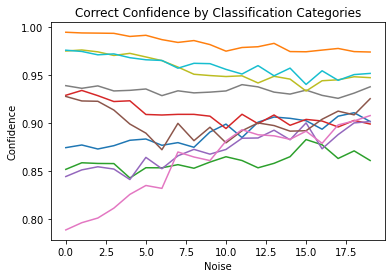

<Figure size 432x288 with 0 Axes>

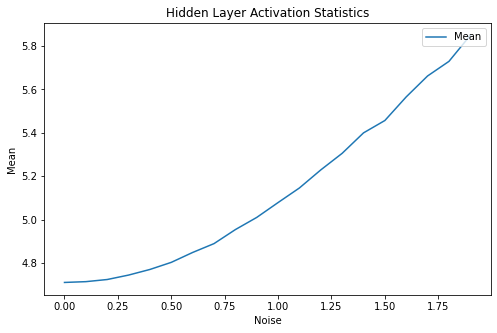

In [28]:
# Vary noise


sd_test = np.arange(0,2,.1)

all_conf_array = []
correct_conf_array = []
acc_array = []

conf_cat_all_array = np.empty((10,0))
conf_cat_correct_array = np.empty((10,0))
freq_all = np.empty((10,0))

activation_mean = []

for i in range(len(sd_test)):
    images_testing_noise = generate_gaussian_noise(images_testing,sd_test[i])
    images_testing_noise_flat = images_testing_noise.reshape(np.shape(images_testing_noise)[0],784)
    labels_testing_predicted = model_feedforward.predict(images_testing_noise_flat)
    
    all_conf,correct_conf = compute_confidence(labels_testing,labels_testing_predicted)
    acc = compute_accuracy(labels_testing,labels_testing_predicted)
    
    all_conf_array.append(all_conf)
    correct_conf_array.append(correct_conf)   
    acc_array.append(acc)
    
    freq = compute_frequencies(labels_testing_predicted)
    
    freq_all = np.hstack((freq_all,freq))
    
    conf_cat_all, conf_cat_correct = compute_confidence_by_category(labels_testing,labels_testing_predicted)
    

    
    conf_cat_all_array = np.hstack((conf_cat_all_array,conf_cat_all))
    conf_cat_correct_array = np.hstack((conf_cat_correct_array,conf_cat_correct))
    
    
    hidden_activation = model_feedforward_intermed.predict(images_testing_noise_flat)
    
    activation_mean.append(np.mean(hidden_activation))

plt.figure(1)
fig, acc_ax = plt.subplots(figsize=(8,5))
conf_ax = acc_ax.twinx()
acc_ax.set_xlabel("Noise")
acc_ax.set_ylabel("Accuracy")
conf_ax.set_ylabel("Confidence")
acc_ax.plot(sd_test,acc_array, label = "Accuracy")
conf_ax.plot(sd_test,all_conf_array, label = "Overall Confidence",color='r')
conf_ax.plot(sd_test,correct_conf_array, label = "Correct Confidence",color='g')
plt.title("Feedforward Network")
conf_ax.legend(loc= "upper right")
acc_ax.legend(loc= "upper left")
plt.show()

plt.figure(2)
for i in range(10):
    plt.plot(freq_all[i,:])

plt.xlabel("Noise")
plt.ylabel("Proportion Predicted")
plt.title("Classification Frequencies")
plt.show()

plt.figure(3)
for i in range(10):
    plt.plot(conf_cat_all_array[i,:])

plt.xlabel("Noise")
plt.ylabel("Confidence")
plt.title("Confidence by Classification Categories")
plt.show()

plt.figure(4)
for i in range(10):
    plt.plot(conf_cat_correct_array[i,:])

plt.xlabel("Noise")
plt.ylabel("Confidence")
plt.title("Correct Confidence by Classification Categories")
plt.show()


plt.figure(5)
fig, mean_ax = plt.subplots(figsize=(8,5))
#var_ax = mean_ax.twinx()
mean_ax.set_xlabel("Noise")
mean_ax.set_ylabel("Mean")
#var_ax.set_ylabel("Variance")
mean_ax.plot(sd_test,activation_mean, label = "Mean")
#var_ax.plot(sd_test,activation_var, label = "Var",color='r')
plt.title("Hidden Layer Activation Statistics")
mean_ax.legend(loc= "upper right")
#var_ax.legend(loc= "upper left")
plt.show()

In [29]:
#Train standard feedforward model

dropout_level = 0.3

images_training_noise = generate_dropout_pixel_range(images_training,dropout_level)

images_training_flat = images_training_noise.reshape(np.shape(images_training)[0],784)

inputs = Input(shape=(784))
layer = Dense(10,activation='relu')(inputs)


outputs = Dense(10,activation='softmax')(layer)

model_feedforward = Model(inputs=inputs,outputs=outputs)

model_feedforward_intermed = Model(inputs=inputs,outputs=layer)

model_feedforward.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_feedforward.fit(images_training_flat,labels_training,batch_size=100,verbose = 0, epochs=500,validation_split=0.33,callbacks=[es])


Epoch 25: early stopping


313/313 [==============================] - 0s 580us/step


<Figure size 432x288 with 0 Axes>

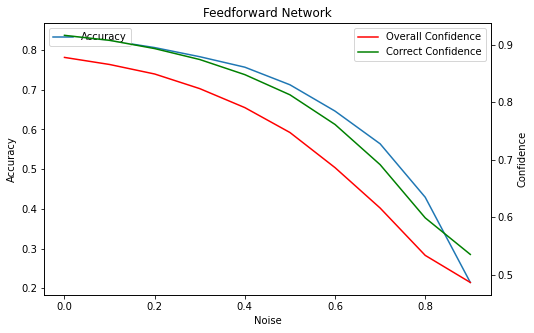

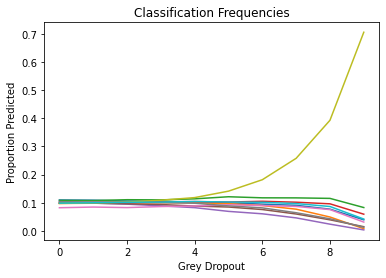

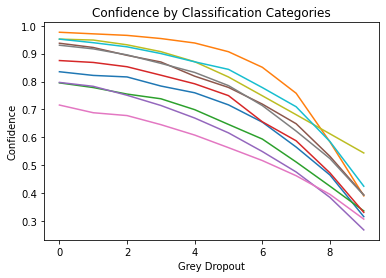

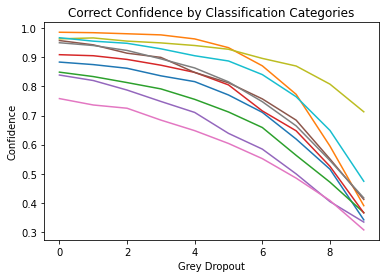

<Figure size 432x288 with 0 Axes>

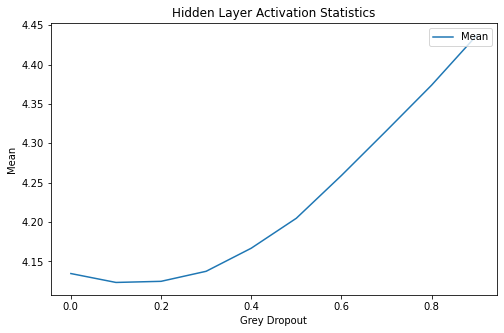

In [30]:
# Vary grey dropout


sd_test = np.arange(0,1,.1)

all_conf_array = []
correct_conf_array = []
acc_array = []

conf_cat_all_array = np.empty((10,0))
conf_cat_correct_array = np.empty((10,0))
freq_all = np.empty((10,0))

activation_mean = []

for i in range(len(sd_test)):
    images_testing_noise = generate_pixel_dropout(images_testing,sd_test[i],0.5)
    images_testing_noise_flat = images_testing_noise.reshape(np.shape(images_testing_noise)[0],784)
    labels_testing_predicted = model_feedforward.predict(images_testing_noise_flat)
    
    all_conf,correct_conf = compute_confidence(labels_testing,labels_testing_predicted)
    acc = compute_accuracy(labels_testing,labels_testing_predicted)
    
    all_conf_array.append(all_conf)
    correct_conf_array.append(correct_conf)   
    acc_array.append(acc)
    
    freq = compute_frequencies(labels_testing_predicted)
    
    freq_all = np.hstack((freq_all,freq))
    
    conf_cat_all, conf_cat_correct = compute_confidence_by_category(labels_testing,labels_testing_predicted)
    

    
    conf_cat_all_array = np.hstack((conf_cat_all_array,conf_cat_all))
    conf_cat_correct_array = np.hstack((conf_cat_correct_array,conf_cat_correct))
    
    
    hidden_activation = model_feedforward_intermed.predict(images_testing_noise_flat)
    
    activation_mean.append(np.mean(hidden_activation))

plt.figure(1)
fig, acc_ax = plt.subplots(figsize=(8,5))
conf_ax = acc_ax.twinx()
acc_ax.set_xlabel("Noise")
acc_ax.set_ylabel("Accuracy")
conf_ax.set_ylabel("Confidence")
acc_ax.plot(sd_test,acc_array, label = "Accuracy")
conf_ax.plot(sd_test,all_conf_array, label = "Overall Confidence",color='r')
conf_ax.plot(sd_test,correct_conf_array, label = "Correct Confidence",color='g')
plt.title("Feedforward Network")
conf_ax.legend(loc= "upper right")
acc_ax.legend(loc= "upper left")
plt.show()

plt.figure(2)
for i in range(10):
    plt.plot(freq_all[i,:])

plt.xlabel("Grey Dropout")
plt.ylabel("Proportion Predicted")
plt.title("Classification Frequencies")
plt.show()

plt.figure(3)
for i in range(10):
    plt.plot(conf_cat_all_array[i,:])

plt.xlabel("Grey Dropout")
plt.ylabel("Confidence")
plt.title("Confidence by Classification Categories")
plt.show()

plt.figure(4)
for i in range(10):
    plt.plot(conf_cat_correct_array[i,:])

plt.xlabel("Grey Dropout")
plt.ylabel("Confidence")
plt.title("Correct Confidence by Classification Categories")
plt.show()


plt.figure(5)
fig, mean_ax = plt.subplots(figsize=(8,5))
#var_ax = mean_ax.twinx()
mean_ax.set_xlabel("Grey Dropout")
mean_ax.set_ylabel("Mean")
#var_ax.set_ylabel("Variance")
mean_ax.plot(sd_test,activation_mean, label = "Mean")
#var_ax.plot(sd_test,activation_var, label = "Var",color='r')
plt.title("Hidden Layer Activation Statistics")
mean_ax.legend(loc= "upper right")
#var_ax.legend(loc= "upper left")
plt.show()

313/313 [==============================] - 0s 562us/step


<Figure size 432x288 with 0 Axes>

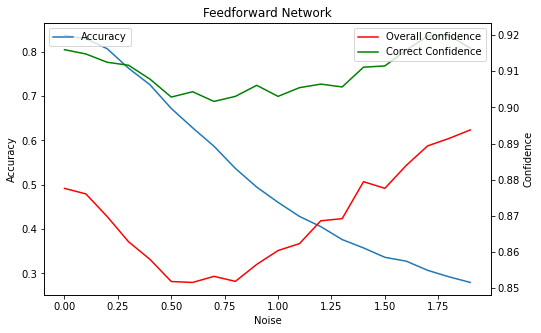

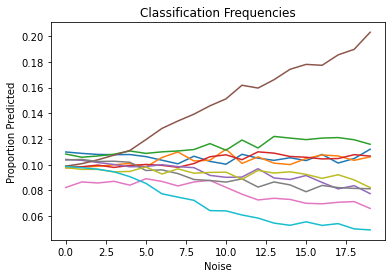

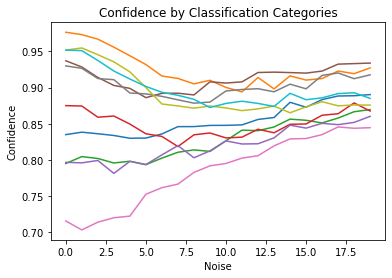

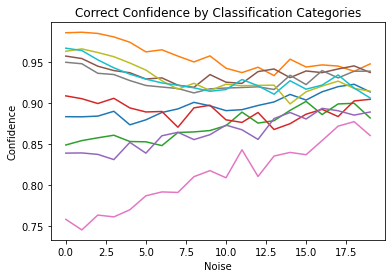

<Figure size 432x288 with 0 Axes>

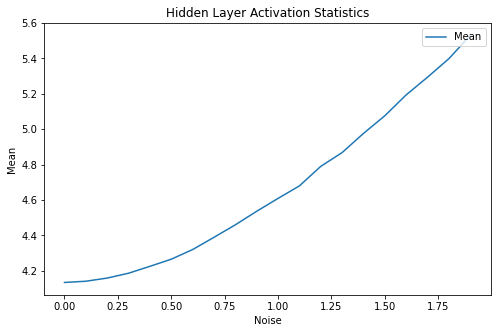

In [31]:
# Vary noise


sd_test = np.arange(0,2,.1)

all_conf_array = []
correct_conf_array = []
acc_array = []

conf_cat_all_array = np.empty((10,0))
conf_cat_correct_array = np.empty((10,0))
freq_all = np.empty((10,0))

activation_mean = []

for i in range(len(sd_test)):
    images_testing_noise = generate_gaussian_noise(images_testing,sd_test[i])
    images_testing_noise_flat = images_testing_noise.reshape(np.shape(images_testing_noise)[0],784)
    labels_testing_predicted = model_feedforward.predict(images_testing_noise_flat)
    
    all_conf,correct_conf = compute_confidence(labels_testing,labels_testing_predicted)
    acc = compute_accuracy(labels_testing,labels_testing_predicted)
    
    all_conf_array.append(all_conf)
    correct_conf_array.append(correct_conf)   
    acc_array.append(acc)
    
    freq = compute_frequencies(labels_testing_predicted)
    
    freq_all = np.hstack((freq_all,freq))
    
    conf_cat_all, conf_cat_correct = compute_confidence_by_category(labels_testing,labels_testing_predicted)
    

    
    conf_cat_all_array = np.hstack((conf_cat_all_array,conf_cat_all))
    conf_cat_correct_array = np.hstack((conf_cat_correct_array,conf_cat_correct))
    
    
    hidden_activation = model_feedforward_intermed.predict(images_testing_noise_flat)
    
    activation_mean.append(np.mean(hidden_activation))

plt.figure(1)
fig, acc_ax = plt.subplots(figsize=(8,5))
conf_ax = acc_ax.twinx()
acc_ax.set_xlabel("Noise")
acc_ax.set_ylabel("Accuracy")
conf_ax.set_ylabel("Confidence")
acc_ax.plot(sd_test,acc_array, label = "Accuracy")
conf_ax.plot(sd_test,all_conf_array, label = "Overall Confidence",color='r')
conf_ax.plot(sd_test,correct_conf_array, label = "Correct Confidence",color='g')
plt.title("Feedforward Network")
conf_ax.legend(loc= "upper right")
acc_ax.legend(loc= "upper left")
plt.show()

plt.figure(2)
for i in range(10):
    plt.plot(freq_all[i,:])

plt.xlabel("Noise")
plt.ylabel("Proportion Predicted")
plt.title("Classification Frequencies")
plt.show()

plt.figure(3)
for i in range(10):
    plt.plot(conf_cat_all_array[i,:])

plt.xlabel("Noise")
plt.ylabel("Confidence")
plt.title("Confidence by Classification Categories")
plt.show()

plt.figure(4)
for i in range(10):
    plt.plot(conf_cat_correct_array[i,:])

plt.xlabel("Noise")
plt.ylabel("Confidence")
plt.title("Correct Confidence by Classification Categories")
plt.show()


plt.figure(5)
fig, mean_ax = plt.subplots(figsize=(8,5))
#var_ax = mean_ax.twinx()
mean_ax.set_xlabel("Noise")
mean_ax.set_ylabel("Mean")
#var_ax.set_ylabel("Variance")
mean_ax.plot(sd_test,activation_mean, label = "Mean")
#var_ax.plot(sd_test,activation_var, label = "Var",color='r')
plt.title("Hidden Layer Activation Statistics")
mean_ax.legend(loc= "upper right")
#var_ax.legend(loc= "upper left")
plt.show()

# Test grey dropout on no noise training

In [19]:
#Train standard feedforward model

images_training_flat = images_training.reshape(np.shape(images_training)[0],784)

inputs = Input(shape=(784))
layer = Dense(10,activation='relu')(inputs)


outputs = Dense(10,activation='softmax')(layer)

model_feedforward = Model(inputs=inputs,outputs=outputs)

model_feedforward_intermed = Model(inputs=inputs,outputs=layer)

model_feedforward.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_feedforward.fit(images_training_flat,labels_training,batch_size=100,verbose = 0, epochs=500,validation_split=0.33,callbacks=[es])


Epoch 46: early stopping


313/313 [==============================] - 0s 567us/step


C:\Users\samue\AppData\Local\Temp\ipykernel_33264\1708496032.py:124: RuntimeWarning: invalid value encountered in true_divide
  all_conf[j] = all_conf[j]/cc[j]
C:\Users\samue\AppData\Local\Temp\ipykernel_33264\1708496032.py:125: RuntimeWarning: invalid value encountered in true_divide
  correct_conf[j] = correct_conf[j]/c[j]


313/313 [==============================] - 0s 522us/step


<Figure size 432x288 with 0 Axes>

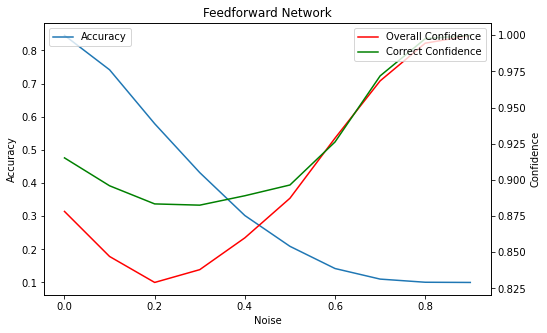

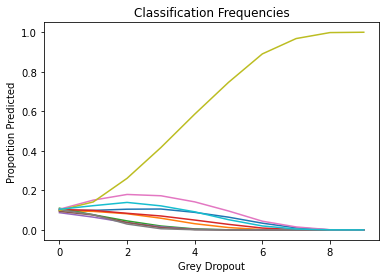

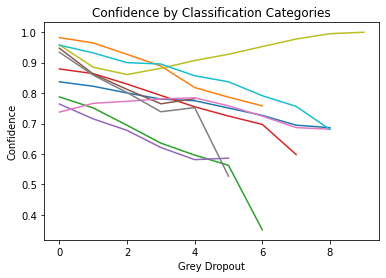

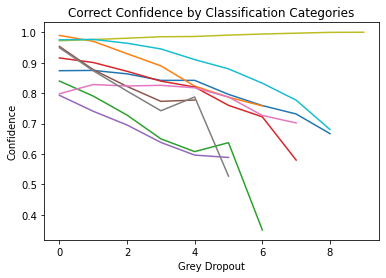

<Figure size 432x288 with 0 Axes>

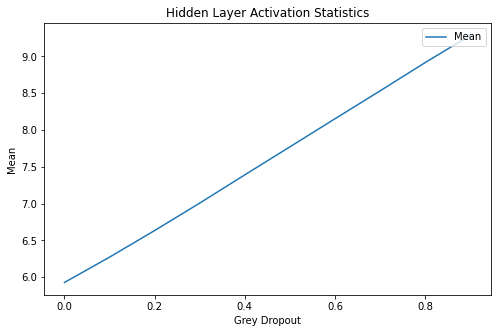

In [20]:
# Vary grey dropout


sd_test = np.arange(0,1,.1)

all_conf_array = []
correct_conf_array = []
acc_array = []

conf_cat_all_array = np.empty((10,0))
conf_cat_correct_array = np.empty((10,0))
freq_all = np.empty((10,0))

activation_mean = []

for i in range(len(sd_test)):
    images_testing_noise = generate_pixel_dropout(images_testing,sd_test[i],0.5)
    images_testing_noise_flat = images_testing_noise.reshape(np.shape(images_testing_noise)[0],784)
    labels_testing_predicted = model_feedforward.predict(images_testing_noise_flat)
    
    all_conf,correct_conf = compute_confidence(labels_testing,labels_testing_predicted)
    acc = compute_accuracy(labels_testing,labels_testing_predicted)
    
    all_conf_array.append(all_conf)
    correct_conf_array.append(correct_conf)   
    acc_array.append(acc)
    
    freq = compute_frequencies(labels_testing_predicted)
    
    freq_all = np.hstack((freq_all,freq))
    
    conf_cat_all, conf_cat_correct = compute_confidence_by_category(labels_testing,labels_testing_predicted)
    

    
    conf_cat_all_array = np.hstack((conf_cat_all_array,conf_cat_all))
    conf_cat_correct_array = np.hstack((conf_cat_correct_array,conf_cat_correct))
    
    
    hidden_activation = model_feedforward_intermed.predict(images_testing_noise_flat)
    
    activation_mean.append(np.mean(hidden_activation))

plt.figure(1)
fig, acc_ax = plt.subplots(figsize=(8,5))
conf_ax = acc_ax.twinx()
acc_ax.set_xlabel("Noise")
acc_ax.set_ylabel("Accuracy")
conf_ax.set_ylabel("Confidence")
acc_ax.plot(sd_test,acc_array, label = "Accuracy")
conf_ax.plot(sd_test,all_conf_array, label = "Overall Confidence",color='r')
conf_ax.plot(sd_test,correct_conf_array, label = "Correct Confidence",color='g')
plt.title("Feedforward Network")
conf_ax.legend(loc= "upper right")
acc_ax.legend(loc= "upper left")
plt.show()

plt.figure(2)
for i in range(10):
    plt.plot(freq_all[i,:])

plt.xlabel("Grey Dropout")
plt.ylabel("Proportion Predicted")
plt.title("Classification Frequencies")
plt.show()

plt.figure(3)
for i in range(10):
    plt.plot(conf_cat_all_array[i,:])

plt.xlabel("Grey Dropout")
plt.ylabel("Confidence")
plt.title("Confidence by Classification Categories")
plt.show()

plt.figure(4)
for i in range(10):
    plt.plot(conf_cat_correct_array[i,:])

plt.xlabel("Grey Dropout")
plt.ylabel("Confidence")
plt.title("Correct Confidence by Classification Categories")
plt.show()


plt.figure(5)
fig, mean_ax = plt.subplots(figsize=(8,5))
#var_ax = mean_ax.twinx()
mean_ax.set_xlabel("Grey Dropout")
mean_ax.set_ylabel("Mean")
#var_ax.set_ylabel("Variance")
mean_ax.plot(sd_test,activation_mean, label = "Mean")
#var_ax.plot(sd_test,activation_var, label = "Var",color='r')
plt.title("Hidden Layer Activation Statistics")
mean_ax.legend(loc= "upper right")
#var_ax.legend(loc= "upper left")
plt.show()